In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
train_df.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [5]:
train_df[['keyword', 'location']].describe()

,keyword,location
count,7552,5080
unique,221,3341
top,fatalities,USA
freq,45,104


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_df.text, train_df.target, test_size=.2, random_state=42)

In [7]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [8]:
X_train_token = tokenizer(X_train.to_list(), truncation=True, padding=True)
X_val_token = tokenizer(X_val.to_list(), truncation=True, padding=True)

In [9]:
import torch

class TwitterDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.X = X
        self.y = y
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.X.items()}
        if self.y is not None:
            item['labels'] = torch.tensor(self.y[idx])
        return item
    
    def __len__(self):
        return len(self.X.input_ids)

train_dataset = TwitterDataset(X_train_token, y_train.to_list())
val_dataset = TwitterDataset(X_val_token, y_val.to_list())

In [10]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [11]:
from transformers import TrainerCallback

class MyCallback(TrainerCallback):
    def __init__(self, logs):
        super().__init__()
        self.logs = logs

    def on_log(self, args, state, control, logs=None, **kwargs):
        self.logs.append(logs)

In [12]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='/kaggle/temp/results',
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=.01,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1',
    dataloader_num_workers=1,
    evaluation_strategy='steps',
    report_to='none' # kaggle doesn't support tensorboard
)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
logs = []
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[MyCallback(logs), EarlyStoppingCallback(early_stopping_patience=10, early_stopping_threshold=.001)]
)
trainer.train()

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
5,0.692800,0.691835,0.561392,0.037464,0.288889,0.020031,1.701500,895.104000
10,0.693000,0.690866,0.565988,0.035036,0.333333,0.018490,1.734200,878.238000
15,0.693200,0.689226,0.569271,0.023810,0.347826,0.012327,2.065300,737.418000
20,0.692000,0.686610,0.571898,0.021021,0.411765,0.010786,1.678700,907.250000
25,0.681700,0.683144,0.575181,0.012214,0.666667,0.006163,1.647500,924.426000
30,0.685300,0.678778,0.576494,0.012251,1.000000,0.006163,1.665800,914.293000
35,0.688600,0.673935,0.580433,0.039098,0.812500,0.020031,1.689300,901.550000
40,0.664200,0.667961,0.591596,0.098551,0.829268,0.052388,1.657500,918.859000
45,0.665600,0.659846,0.600788,0.133903,0.886792,0.072419,1.751900,869.364000
50,0.654000,0.648741,0.636901,0.269485,0.944444,0.157165,1.666200,914.050000


TrainOutput(global_step=210, training_loss=0.49611765770685107, metrics={'train_runtime': 513.5034, 'train_samples_per_second': 0.935, 'total_flos': 449892673433280.0, 'epoch': 2.19, 'init_mem_cpu_alloc_delta': 1824161792, 'init_mem_gpu_alloc_delta': 268953088, 'init_mem_cpu_peaked_delta': 206753792, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 531288064, 'train_mem_gpu_alloc_delta': 1085713408, 'train_mem_cpu_peaked_delta': 187498496, 'train_mem_gpu_peaked_delta': 1893279232})

<Figure size 432x288 with 0 Axes>

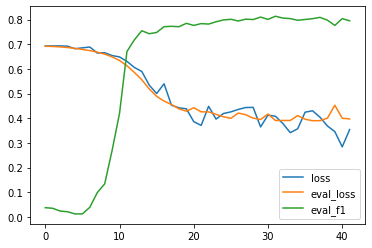

In [13]:
import matplotlib.pyplot as plt

loss, eval_loss, eval_f1 = [], [], []
for log in logs[0:-1]:
    if 'loss' in log:
        loss.append(log['loss'])
    else:
        eval_loss.append(log['eval_loss'])
        eval_f1.append(log['eval_f1'])
train_stats = pd.DataFrame({'loss': loss, 'eval_loss': eval_loss, 'eval_f1': eval_f1})
plt.figure()
train_stats.plot()
plt.legend()

In [14]:
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
X_test_token = tokenizer(test_df.text.to_list(), truncation=True, padding=True)
test_dataset = TwitterDataset(X_test_token)
preds = trainer.predict(test_dataset)
output = pd.DataFrame({'id': test_df.id, 'target': preds.predictions.argmax(axis=1)})
output.to_csv('submission.csv', index=False)